In [1]:
import arrayfire as af
import numpy as np
import pylab as pl

from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear.nonlinear_solver import nonlinear_solver
from bolt.lib.linear.linear_solver import linear_solver

import domain
import boundary_conditions
import params
import initialize

import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moments as moments

%matplotlib inline

# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [12]:
# Time parameters:
t_final = 0.1
N       = 512

domain.N_q1 = int(N)
domain.N_p1 = int(N)

dt = 32*1e-3/N

# Defining the physical system to be solved:
system = physical_system(domain,
                         boundary_conditions,
                         params,
                         initialize,
                         advection_terms,
                         collision_operator.BGK,
                         moments
                        )

N_g_q = system.N_ghost_q

# Declaring a linear system object which will evolve the defined physical system:
nls = nonlinear_solver(system)
ls  = linear_solver(system)

In [13]:
time_array  = np.arange(dt, t_final + dt, dt)

rho_data_nls = np.zeros(time_array.size)
rho_data_ls  = np.zeros(time_array.size)

# Storing data at time t = 0:
n_nls           = nls.compute_moments('density')
rho_data_nls[0] = af.max(n_nls[:, :, N_g_q:-N_g_q, N_g_q:-N_g_q])

n_ls           = ls.compute_moments('density')
rho_data_ls[0] = af.max(n_ls) 

for time_index, t0 in enumerate(time_array):

    print('time_step = ', time_index, 'of ', time_array.size)
    nls.strang_timestep(dt)
    ls.RK4_timestep(dt)

    n_nls                     = nls.compute_moments('density')
    #rho_data_nls[time_index]  = af.max(n_nls[:, :, N_g_q:-N_g_q, N_g_q:-N_g_q])
    
    n_ls                    = ls.compute_moments('density')
    #rho_data_ls[time_index] = af.max(n_ls) 

nls.dump_distribution_function('dump_files/nlsf_' + str(N))
ls.dump_distribution_function('dump_files/lsf_' + str(N))

time_step =  0 of  1600
time_step =  1 of  1600
time_step =  2 of  1600
time_step =  3 of  1600
time_step =  4 of  1600
time_step =  5 of  1600
time_step =  6 of  1600
time_step =  7 of  1600
time_step =  8 of  1600
time_step =  9 of  1600
time_step =  10 of  1600
time_step =  11 of  1600
time_step =  12 of  1600
time_step =  13 of  1600
time_step =  14 of  1600
time_step =  15 of  1600
time_step =  16 of  1600
time_step =  17 of  1600
time_step =  18 of  1600
time_step =  19 of  1600
time_step =  20 of  1600
time_step =  21 of  1600
time_step =  22 of  1600
time_step =  23 of  1600
time_step =  24 of  1600
time_step =  25 of  1600
time_step =  26 of  1600
time_step =  27 of  1600
time_step =  28 of  1600
time_step =  29 of  1600
time_step =  30 of  1600
time_step =  31 of  1600
time_step =  32 of  1600
time_step =  33 of  1600
time_step =  34 of  1600
time_step =  35 of  1600
time_step =  36 of  1600
time_step =  37 of  1600
time_step =  38 of  1600
time_step =  39 of  1600
time_step 

In [14]:
import h5py

# Checking the errors
def check_convergence():
    N     = np.array([32, 64, 128, 256, 512])
    error = np.zeros(N.size)
    
    for i in range(N.size):

        print("N = ", i)
        h5f   = h5py.File('dump_files/nlsf_' + str(N[i]) + '.h5')
        nls_f = h5f['distribution_function'][:]
        h5f.close()    

        h5f  = h5py.File('dump_files/lsf_' + str(N[i]) + '.h5')
        ls_f = h5f['distribution_function'][:]
        h5f.close()

        error[i] = np.mean(abs(nls_f - ls_f))

    print(error)
    poly = np.polyfit(np.log10(N), np.log10(error), 1)
    print(poly)

    pl.loglog(N, error, 'o-', label = 'Numerical')
    pl.loglog(N, error[0]*32**2/N**2, '--', color = 'black', 
              label = r'$O(N^{-2})$'
             )
    pl.legend(loc = 'best')
    pl.ylabel('Error')
    pl.xlabel('$N$')

N =  0
N =  1
N =  2
N =  3
N =  4
[  5.85599278e-07   1.43033312e-07   3.55908369e-08   9.03674487e-09
   2.64662318e-09]
[-1.95636385 -3.30691458]


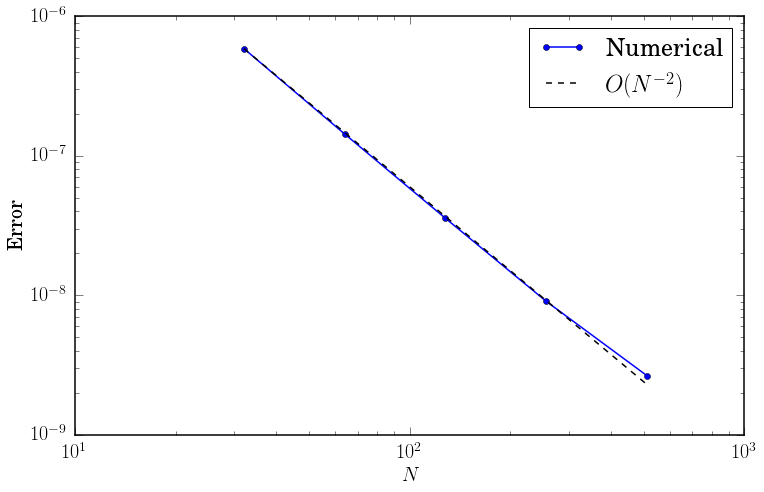

In [15]:
check_convergence()